КЛАССИФИКАЦИЯ ДЛЯ IC50

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

sns.set_style("whitegrid")

In [2]:
print("Загрузка обработанного датафрейма")
processed_excel_file = 'processed_compounds_data.xlsx'
df = pd.read_excel(processed_excel_file)

Загрузка обработанного датафрейма


In [3]:
# Определяем медианы для логарифмированных значений
median_log_IC50 = df['log_IC50'].median()
median_log_CC50 = df['log_CC50'].median()
median_log_SI = df['log_SI'].median()

print(f"Медиана log_IC50: {median_log_IC50:.4f}")
print(f"Медиана log_CC50: {median_log_CC50:.4f}")
print(f"Медиана log_SI: {median_log_SI:.4f}")

# Создаем бинарные целевые переменные: 1, если значение > медианы, иначе 0
# Меньше IC50 -> более активное
# Меньше CC50 -> менее токсичное
# Больше SI -> более селективное
# Замечание: в биологии и химии часто "активность" (IC50) оценивается по МЕНЬШИМ значениям.
# Мы создаем классы "превышает медиану", т.е. для IC50 и CC50 это означает "менее активно/более токсично".
# Для SI "превышает медиану" означает "более селективно".
# Важно четко понимать, что означает "1" для каждого класса.

# Для IC50: '1' если log_IC50 > median_log_IC50 (т.е. менее активно)
df['IC50_binary_class'] = (df['log_IC50'] > median_log_IC50).astype(int)
# Для CC50: '1' если log_CC50 > median_log_CC50 (т.е. менее токсично)
df['CC50_binary_class'] = (df['log_CC50'] > median_log_CC50).astype(int)
# Для SI: '1' если log_SI > median_log_SI (т.е. более селективно)
df['SI_binary_class'] = (df['log_SI'] > median_log_SI).astype(int)

print("Распределение классов для IC50_binary_class:")
print(df['IC50_binary_class'].value_counts(normalize=True))
print("Распределение классов для CC50_binary_class:")
print(df['CC50_binary_class'].value_counts(normalize=True))
print("Распределение классов для SI_binary_class:")
print(df['SI_binary_class'].value_counts(normalize=True))

Медиана log_IC50: 1.6682
Медиана log_CC50: 2.6139
Медиана log_SI: 0.5850
Распределение классов для IC50_binary_class:
IC50_binary_class
0    0.5005
1    0.4995
Name: proportion, dtype: float64
Распределение классов для CC50_binary_class:
CC50_binary_class
0    0.501499
1    0.498501
Name: proportion, dtype: float64
Распределение классов для SI_binary_class:
SI_binary_class
0    0.5005
1    0.4995
Name: proportion, dtype: float64


In [4]:
# Определяем список всех дескрипторов (признаков), исключая все целевые переменные
# (исходные и логарифмированные, а также новые бинарные)
all_feature_columns = [
    col for col in df.columns
    if col not in ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50', 'log_CC50', 'log_SI',
                    'IC50_binary_class', 'CC50_binary_class', 'SI_binary_class']
    and df[col].dtype in ['float64', 'int64']
]

print(f"Общее количество доступных признаков-дескрипторов для классификации: {len(all_feature_columns)}")

Общее количество доступных признаков-дескрипторов для классификации: 163


In [5]:
# Функция для оценки классификационной модели
def evaluate_classifier(model, X_test, y_test, target_name, model_name):
    """
    Оценивает классификационную модель, выводит метрики и строит ROC-кривую.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Вероятности для ROC AUC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # zero_division=0, чтобы избежать предупреждений
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- Результаты для {model_name} (Классификация {target_name}) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("Матрица ошибок (Confusion Matrix):")
    print(confusion_matrix(y_test, y_pred))
    print("Отчет о классификации (Classification Report):")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Визуализация ROC-кривой
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {target_name} ({model_name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return {'model_name': model_name, 'target': target_name,
            'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
            'F1-score': f1, 'ROC AUC': roc_auc}

In [6]:
# Настройка гиперпараметров и обучение моделей для каждой задачи
classification_results_summary = [] # Для сбора результатов всех классификаторов

# Общие параметры для GridSearchCV
grid_cv_params = {
    'cv': 5,
    'scoring': 'roc_auc', # Используем ROC AUC для оценки, т.к. она хороша при несбалансированных классах
    'n_jobs': -1,
    'verbose': 0 # Можно изменить на 1 или 2 для более подробного вывода
}

In [7]:
# КЛАССИФИКАЦИЯ ДЛЯ IC50
# Создаем набор признаков, исключая CC50, SI и их логарифмированные/бинарные версии
X_ic50_clf_features = [col for col in all_feature_columns if 'CC50' not in col and 'SI' not in col]
y_ic50_clf = df['IC50_binary_class']
X_ic50_clf = df[X_ic50_clf_features]


X_train_ic50_clf, X_test_ic50_clf, y_train_ic50_clf, y_test_ic50_clf = train_test_split(X_ic50_clf, y_ic50_clf, test_size=0.2, random_state=42, stratify=y_ic50_clf)

scaler_ic50_clf = StandardScaler()
X_train_ic50_clf_scaled = scaler_ic50_clf.fit_transform(X_train_ic50_clf)
X_test_ic50_clf_scaled = scaler_ic50_clf.transform(X_test_ic50_clf)

Настройка гиперпараметров для Logistic Regression (IC50_binary_class)
Лучшие гиперпараметры для Logistic Regression (IC50): {'C': 0.01}

--- Результаты для Logistic Regression (Классификация IC50_binary_class) ---
Accuracy: 0.6866
Precision: 0.6637
Recall: 0.7500
F1-score: 0.7042
ROC AUC: 0.7536
Матрица ошибок (Confusion Matrix):
[[63 38]
 [25 75]]
Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       101
           1       0.66      0.75      0.70       100

    accuracy                           0.69       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.69      0.69      0.69       201



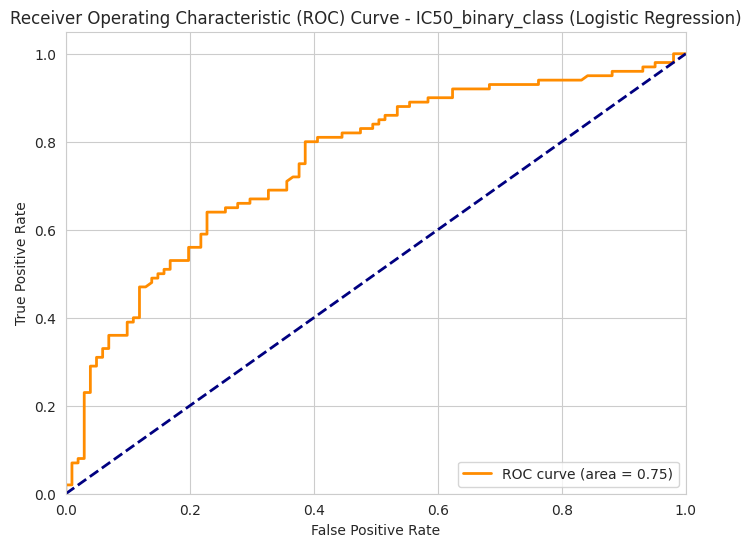

In [8]:
# 1. Logistic Regression
print("Настройка гиперпараметров для Logistic Regression (IC50_binary_class)")
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]} # C - обратная сила регуляризации
grid_search_lr_ic50 = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid_lr, **grid_cv_params)
grid_search_lr_ic50.fit(X_train_ic50_clf_scaled, y_train_ic50_clf)
best_lr_ic50 = grid_search_lr_ic50.best_estimator_
print(f"Лучшие гиперпараметры для Logistic Regression (IC50): {grid_search_lr_ic50.best_params_}")
classification_results_summary.append(evaluate_classifier(best_lr_ic50, X_test_ic50_clf_scaled, y_test_ic50_clf, 'IC50_binary_class', 'Logistic Regression'))

Настройка гиперпараметров для Random Forest Classifier (IC50_binary_class)
Лучшие гиперпараметры для Random Forest (IC50): {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}

--- Результаты для Random Forest (Классификация IC50_binary_class) ---
Accuracy: 0.6965
Precision: 0.6639
Recall: 0.7900
F1-score: 0.7215
ROC AUC: 0.7794
Матрица ошибок (Confusion Matrix):
[[61 40]
 [21 79]]
Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.74      0.60      0.67       101
           1       0.66      0.79      0.72       100

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.69       201
weighted avg       0.70      0.70      0.69       201



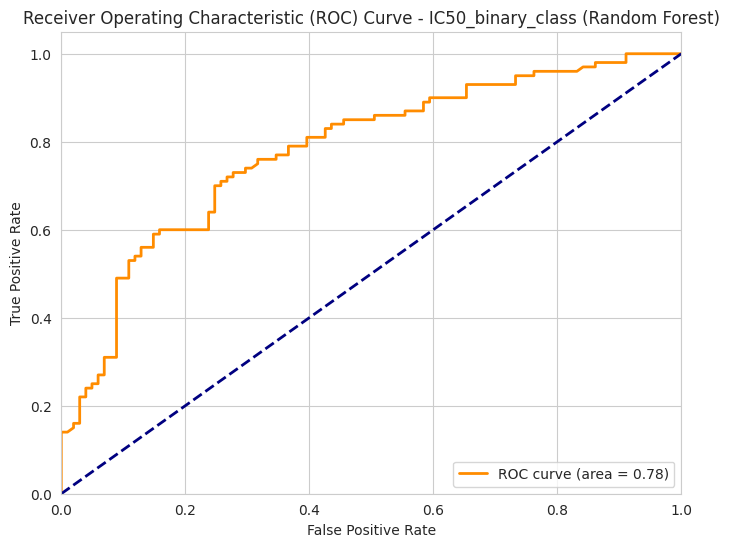

In [9]:
# 2. Random Forest Classifier
print("Настройка гиперпараметров для Random Forest Classifier (IC50_binary_class)")
param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2]}
grid_search_rf_ic50 = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, **grid_cv_params)
grid_search_rf_ic50.fit(X_train_ic50_clf, y_train_ic50_clf)
best_rf_ic50 = grid_search_rf_ic50.best_estimator_
print(f"Лучшие гиперпараметры для Random Forest (IC50): {grid_search_rf_ic50.best_params_}")
classification_results_summary.append(evaluate_classifier(best_rf_ic50, X_test_ic50_clf, y_test_ic50_clf, 'IC50_binary_class', 'Random Forest'))

Настройка гиперпараметров для Gradient Boosting Classifier (IC50_binary_class)
Лучшие гиперпараметры для Gradient Boosting (IC50): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

--- Результаты для Gradient Boosting (Классификация IC50_binary_class) ---
Accuracy: 0.7313
Precision: 0.6949
Recall: 0.8200
F1-score: 0.7523
ROC AUC: 0.7812
Матрица ошибок (Confusion Matrix):
[[65 36]
 [18 82]]
Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.78      0.64      0.71       101
           1       0.69      0.82      0.75       100

    accuracy                           0.73       201
   macro avg       0.74      0.73      0.73       201
weighted avg       0.74      0.73      0.73       201



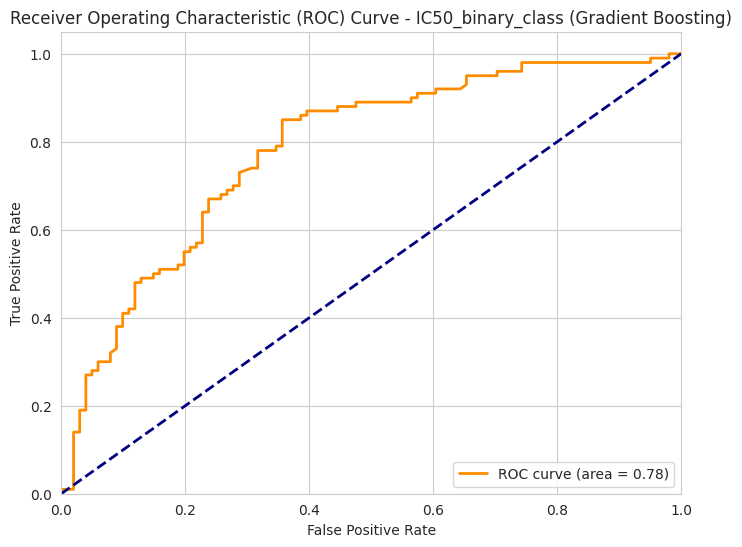

In [10]:
# 3. Gradient Boosting Classifier
print("Настройка гиперпараметров для Gradient Boosting Classifier (IC50_binary_class)")
param_grid_gb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]}
grid_search_gb_ic50 = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, **grid_cv_params)
grid_search_gb_ic50.fit(X_train_ic50_clf, y_train_ic50_clf)
best_gb_ic50 = grid_search_gb_ic50.best_estimator_
print(f"Лучшие гиперпараметры для Gradient Boosting (IC50): {grid_search_gb_ic50.best_params_}")
classification_results_summary.append(evaluate_classifier(best_gb_ic50, X_test_ic50_clf, y_test_ic50_clf, 'IC50_binary_class', 'Gradient Boosting'))


Настройка гиперпараметров для XGBoost Classifier (IC50_binary_class)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие гиперпараметры для XGBoost (IC50): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'use_label_encoder': False}

--- Результаты для XGBoost (Классификация IC50_binary_class) ---
Accuracy: 0.7114
Precision: 0.6909
Recall: 0.7600
F1-score: 0.7238
ROC AUC: 0.7929
Матрица ошибок (Confusion Matrix):
[[67 34]
 [24 76]]
Отчет о классификации (Classification Report):
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       101
           1       0.69      0.76      0.72       100

    accuracy                           0.71       201
   macro avg       0.71      0.71      0.71       201
weighted avg       0.71      0.71      0.71       201



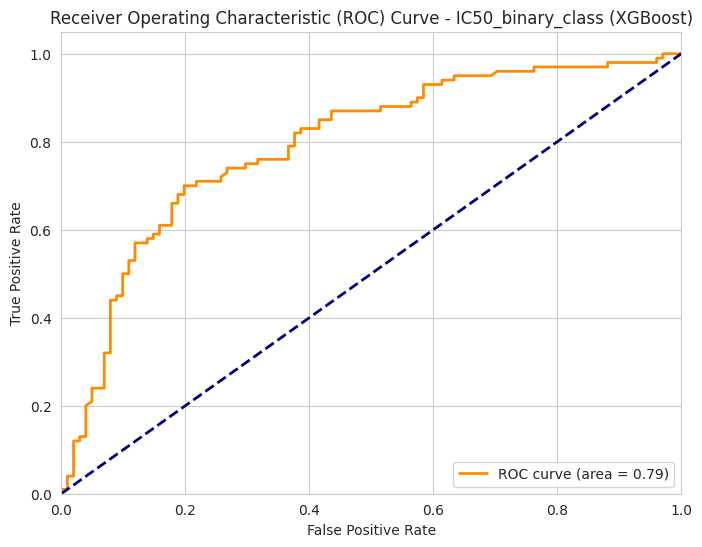

In [11]:
# 4. XGBoost Classifier
print("Настройка гиперпараметров для XGBoost Classifier (IC50_binary_class)")
param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'use_label_encoder': [False]}
grid_search_xgb_ic50 = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42), param_grid_xgb, **grid_cv_params)
grid_search_xgb_ic50.fit(X_train_ic50_clf, y_train_ic50_clf)
best_xgb_ic50 = grid_search_xgb_ic50.best_estimator_
print(f"Лучшие гиперпараметры для XGBoost (IC50): {grid_search_xgb_ic50.best_params_}")
classification_results_summary.append(evaluate_classifier(best_xgb_ic50, X_test_ic50_clf, y_test_ic50_clf, 'IC50_binary_class', 'XGBoost'))

In [12]:
# таблица результатов классификации
print("Таблица результатов классификации IC50")
results_clf_df = pd.DataFrame(classification_results_summary)
results_clf_df.sort_values(by=['target', 'ROC AUC'], ascending=[True, False])

Таблица результатов классификации IC50


,model_name,target,Accuracy,Precision,Recall,F1-score,ROC AUC
3,XGBoost,IC50_binary_class,0.711443,0.690909,0.76,0.723810,0.792921
2,Gradient Boosting,IC50_binary_class,0.731343,0.694915,0.82,0.752294,0.781188
1,Random Forest,IC50_binary_class,0.696517,0.663866,0.79,0.721461,0.779356
0,Logistic Regression,IC50_binary_class,0.686567,0.663717,0.75,0.704225,0.753614
